# Feature Engineering (Introduction) 

### In this lesson, we will discuss the problem of feature engineering, and some possible solutions.    

### For this example I will use the file, '2_P3.mat', and attempt to classify the 5 letters presented (ignoring whether they were standards or targets)

## README 

### The information about the datafiles in an experiment is normally placed in a README file. 
### For convenience I am going to place that information here instead.

###  This data was obtained from the archive ERP CORE and reorganized for this class. 
###  Each file contains the data of one participant, indicated in the filename. 
###  The variables contained here are 

*   `ntrials` - number of trials in the experiment 
*   `nchannels` - number of EEG channels 
*   `samplingrate` - number of samples of EEG in per second
*   `eeg` - eegdata of the experiment.  of dimensions, ntrials x nchannels x ntimepoints.  The EEG is provided in units of volts. 
*   `eeg_time` - the time relative to *stimulus onset* in each EEG observation.
*   `channelnames` - the name of the EEG channels indicating where it is located.    
*   `stimulus` - the stimulus presented on each good trial, 1 = A, 2 = B, 3 = C, 4 = D, 5 = E 
*   `target` - the target stimulus on each good trial 1 = A, 2 = B, 3 = C, 4 = D, 5 = E
*   `blocktarget` - indicates which trial had the target on each block, 1 if a target 0 if not a target. 
*   `response` - variable indicating the response accuracy 1 = correct, -1 = incorrect, 0 = no response,
*   `responsetime` - time after stimulus onset when the subject provided a response. 
*   `goodtrials` - vector with value 1 if the trial had a response, 0 if no response or multiple responses.  

In [64]:
from hdf5storage import loadmat
import numpy as np 
from matplotlib import pyplot as plt 
from eeg import makefilter
from scipy import signal

In [65]:
data = loadmat('../Exercises/data/2_P3.mat')
blocktarget = data['blocktarget']
channelnames = data['channelnames']
eeg = data['eeg']
eeg_time = data['eeg_time']
goodtrials = data['goodtrials']
nchannels = data['nchannels']
ntrials = data['ntrials']
response = data['response']
responsetime = data['responsetime']
samplingrate = data['samplingrate']
stimulus = data['stimulus']
target = data['target']
eeg = eeg*10**6

#### 1. Its always best to filter EEG data to minimize noise.  From a previous homework, we learned that the response to the letters required a broader filter, upto around 20 Hz.  Here I did it to 15 Hz, with a stop at 20 Hz. 

In [95]:
fp = 15
fs = 20
b,a,w,h = makefilter(samplingrate,fp,fs) # the parameters b and a contain the filter information. 
eegfilt = signal.filtfilt(b,a,eeg,axis=2) # The orignal data is trial x chan x time.  hence i filter over axis = 2 

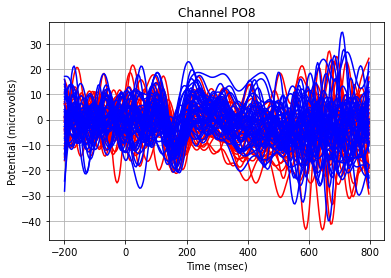

In [99]:
plt.plot(eeg_time,np.transpose(eegfilt[stimulus == 3,25,:]),'r')
plt.plot(eeg_time,np.transpose(eegfilt[stimulus == 1,25,:]),'b')
plt.title('Channel '+channelnames[25])
plt.xlabel('Time (msec)')
plt.ylabel('Potential (microvolts)')
plt.grid()
plt.show()

#### Lets just use LDA to classify all 5 letters at each time point 

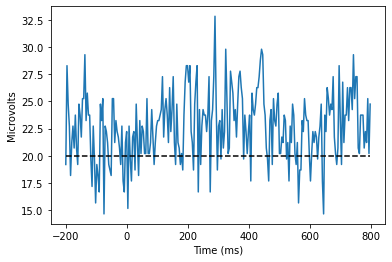

In [100]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import KFold 
kf = KFold(n_splits = 5,shuffle = True)
accuracy_time = np.zeros(256)
for k in range(256):
    z_T = np.squeeze(eeg[:,:,k]) 
    errors = 0
    predictions = np.zeros(np.shape(z_T)[0])
    probability = np.zeros((len(predictions),5))
    clabel = stimulus
    for train_index, test_index in kf.split(z_T):
        #    print("TRAIN:", train_index, "TEST:", test_index)
        data_train = z_T[train_index]
        data_test = z_T[test_index]
        Label_train= clabel[train_index] 
        Label_test = clabel[test_index]
        clf = LDA(n_components =1)
        #clf = svm.SVC()
        data_model = clf.fit(data_train, Label_train)
        predict = clf.predict(data_test)
        test = Label_test == predict
        errors = errors + sum(~test)
        predictions[test_index] = predict
        #    probability[test_index,:] = clf.predict_proba(data_test)
        errorrate = errors/len(clabel)
        accuracy_time[k] = 100*(1-errorrate)
        #plt.plot(np.arange(0,50,1),accuracy_f,'r')
plt.plot(eeg_time,accuracy_time)
plt.plot(eeg_time,20*np.ones(len(eeg_time)),'k--')
plt.xlabel('Time (ms)')
plt.ylabel('Microvolts')
plt.show()

#### Idea #1 Let's compute an ERP, then build a PCA model, to group together similar waveforms that are task relevant.  

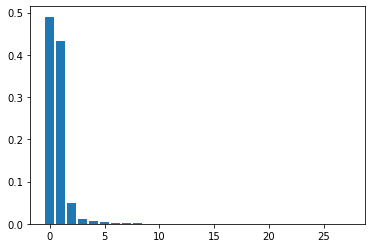

In [69]:
erp = np.mean(eegfilt,axis = 0)
from sklearn.decomposition import PCA 
erppca = PCA()
erppca.fit(np.transpose(erp))
ncomponents = erppca.n_components_
components = erppca.components_
explained_variance = erppca.explained_variance_ratio_
plt.bar(np.arange(ncomponents),explained_variance)
plt.show()

In [70]:
eeg_pca = np.zeros((ntrials,256,ncomponents)) # note that i transposed this relative to original eeg 
for j in range(ntrials):
    trialeeg = np.transpose(np.squeeze(eegfilt[j,:,:]))
    eeg_pca[j,:,] = erppca.transform(trialeeg)

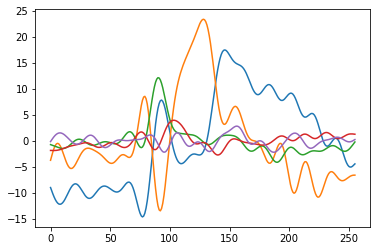

In [71]:
erp_pca = np.mean(eeg_pca,axis = 0)
plt.plot(erp_pca[:,0:5])
plt.show()

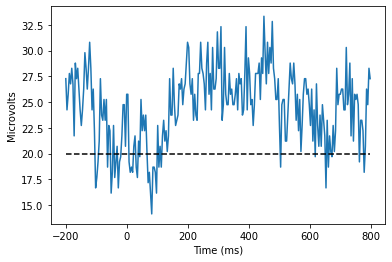

In [78]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import KFold 
kf = KFold(n_splits = 5,shuffle = True)
accuracy_time = np.zeros(256)
for k in range(256):
    z_T = np.squeeze(eeg_pca[:,k,0:10]) #notice I had to flip this
    errors = 0
    predictions = np.zeros(np.shape(z_T)[0])
    probability = np.zeros((len(predictions),5))
    clabel = stimulus
    for train_index, test_index in kf.split(z_T):
        #    print("TRAIN:", train_index, "TEST:", test_index)
        data_train = z_T[train_index]
        data_test = z_T[test_index]
        Label_train= clabel[train_index] 
        Label_test = clabel[test_index]
        clf = LDA(n_components =1)
        #clf = svm.SVC()
        data_model = clf.fit(data_train, Label_train)
        predict = clf.predict(data_test)
        test = Label_test == predict
        errors = errors + sum(~test)
        predictions[test_index] = predict
        #    probability[test_index,:] = clf.predict_proba(data_test)
        errorrate = errors/len(clabel)
        accuracy_time[k] = 100*(1-errorrate)
        #plt.plot(np.arange(0,50,1),accuracy_f,'r')
plt.plot(eeg_time,accuracy_time)
plt.plot(eeg_time,20*np.ones(len(eeg_time)),'k--')
plt.xlabel('Time (ms)')
plt.ylabel('Microvolts')
plt.show()

### Idea #2 Let's aggressively feature engineer 

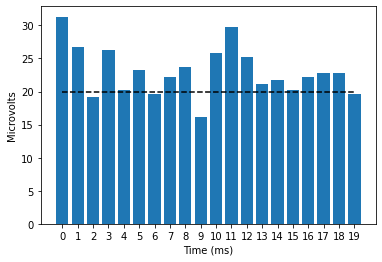

In [104]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import KFold 
kf = KFold(n_splits = 5,shuffle = True)
accuracy_comp = np.zeros(20)
for k in range(20):
    z_T = np.squeeze(eeg_pca[:,:,k]) #notice I had to flip this
    errors = 0
    predictions = np.zeros(np.shape(z_T)[0])
    probability = np.zeros((len(predictions),5))
    clabel = stimulus
    for train_index, test_index in kf.split(z_T):
        #    print("TRAIN:", train_index, "TEST:", test_index)
        data_train = z_T[train_index]
        data_test = z_T[test_index]
        Label_train= clabel[train_index] 
        Label_test = clabel[test_index]
        clf = LDA(n_components =1)
        #clf = svm.SVC()
        data_model = clf.fit(data_train, Label_train)
        predict = clf.predict(data_test)
        test = Label_test == predict
        errors = errors + sum(~test)
        predictions[test_index] = predict
        #    probability[test_index,:] = clf.predict_proba(data_test)
        errorrate = errors/len(clabel)
        accuracy_comp[k] = 100*(1-errorrate)
        #plt.plot(np.arange(0,50,1),accuracy_f,'r')
plt.bar(np.arange(20),accuracy_comp)
plt.plot(np.arange(20),20*np.ones(20),'k--')
plt.xlabel('Time (ms)')
plt.xticks(np.arange(20))
plt.ylabel('Microvolts')
plt.show()

In [91]:
csort = np.flipud(np.argsort(accuracy_comp))

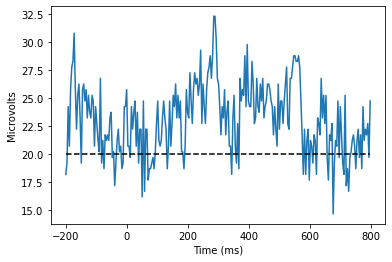

In [92]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import KFold 
kf = KFold(n_splits = 5,shuffle = True)
accuracy_time = np.zeros(256)
for k in range(256):
    z_T = np.squeeze(eeg_pca[:,k,csort[0:5]]) #notice I had to flip this
    errors = 0
    predictions = np.zeros(np.shape(z_T)[0])
    probability = np.zeros((len(predictions),5))
    clabel = stimulus
    for train_index, test_index in kf.split(z_T):
        #    print("TRAIN:", train_index, "TEST:", test_index)
        data_train = z_T[train_index]
        data_test = z_T[test_index]
        Label_train= clabel[train_index] 
        Label_test = clabel[test_index]
        clf = LDA(n_components =1)
        #clf = svm.SVC()
        data_model = clf.fit(data_train, Label_train)
        predict = clf.predict(data_test)
        test = Label_test == predict
        errors = errors + sum(~test)
        predictions[test_index] = predict
        #    probability[test_index,:] = clf.predict_proba(data_test)
        errorrate = errors/len(clabel)
        accuracy_time[k] = 100*(1-errorrate)
        #plt.plot(np.arange(0,50,1),accuracy_f,'r')
plt.plot(eeg_time,accuracy_time)
plt.plot(eeg_time,20*np.ones(len(eeg_time)),'k--')
plt.xlabel('Time (ms)')
plt.ylabel('Microvolts')
plt.show()